# Big Data Experiment

In [1]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import classification_report

from sklearn.ensemble import AdaBoostClassifier

from mlxtend.classifier import EnsembleVoteClassifier
import copy

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

%matplotlib inline

## Exploratory Analysis

In [2]:
path = 'Data/bank-full.csv'

with open(path, encoding="utf8") as f:
    data = pd.read_csv(f, sep=";", encoding="utf8")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
# previous = data['previous']
# plot_retweets = previous.plot.hist()
# plot_retweets.set_xlabel("Number of contacts performed before this campaign", weight='bold', size=12)
# plot_retweets.set_ylabel("Frequency", weight='bold', size=12)

In [6]:
# campaign = data['campaign']
# plot_retweets = campaign.plot.hist()
# plot_retweets.set_xlabel("Number of contacts during before this campaign", weight='bold', size=12)
# plot_retweets.set_ylabel("Frequency", weight='bold', size=12)

In [7]:
# pairplot = sns.pairplot(data)

In [8]:
# correlations = data[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']].corr()
# correlations_matrix = sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, cmap=sns.cubehelix_palette(10))

In [9]:
data.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [10]:
data.y.value_counts(normalize=True)

no     0.883015
yes    0.116985
Name: y, dtype: float64

In [11]:
# Split data into training and test sets
train, test = train_test_split(data, train_size=0.9)

# Encoder
encoder = preprocessing.LabelEncoder()

In [12]:
print(train.size, test.size)

691713 76874


## Functions

In [41]:
# Add the scores to the dataframe
def add_to_results(df, split, f1, acc, result):
    scores = {"Splits": split, "F1-score": f1, "Accuracy": acc, "Result": result}
    df = df.append(scores, ignore_index=True)
    return df

In [42]:
# Split a data set in to X, y and encode X
def splitXy(dataset):
    X = dataset.drop('y', axis=1)
    for column in X.columns:
        if X[column].dtype == 'object':
            X[column] = encoder.fit_transform(X[column])        
    y = dataset.y
    return X, y

In [43]:
# Train voting classifier with n splits
def train_classifier_with_n_splits(n_parts, train):
    # Randomly split data into n parts of (roughly) equal size
    splits = np.array_split(train, indices_or_sections=n_parts)
    
    # Fit a decision tree to every split of data
    classifiers = []
    for i, split in enumerate(splits):
        X_train, y_train = splitXy(split)

        tree_split = tree.DecisionTreeClassifier(max_depth=10)
        tree_split = tree_split.fit(X_train, y_train)
        classifiers.append(tree_split)
        
    # Combine all trees in a voting classifier
    eclf = EnsembleVoteClassifier(clfs=classifiers, voting="soft", refit=False)
    eclf.fit(None, y_train)
    
    return eclf

In [44]:
# Test voting classifier
def validate_classifier(eclf, test):
    X_test, y_test = splitXy(test)
    eclf_report = classification_report(y_test, eclf.predict(X_test), output_dict=True)
    return eclf_report

In [45]:
def my_voting_classifier(n_splits, train, test):
    # Empty dataframe to save results
    results = pd.DataFrame()

    # Repeat for every n of splits: train classifier, 
    for n_split in n_splits:
        eclf = train_classifier_with_n_splits(n_split, train)
        report = validate_classifier(eclf, test)
        results = add_to_results(results, n_split, report['macro avg']['f1-score'], report['accuracy'], report)
        print(n_split, report['macro avg']['f1-score'])
    
    return results

## Voting classifier, training on seperate splits

In [46]:
n_splits = [1, 2, 4, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500]
results = my_voting_classifier(n_splits, train, test)
results

1 0.7273711380439845
2 0.6956785079075134
4 0.7062561691084321
8 0.7068142872048253
10 0.7184640506271501
15 0.7091344868273318
20 0.7108093440232808
25 0.7023994107134233
30 0.7085707231557118
35 0.7113814128747941
40 0.7003205618378479
45 0.703692067960189
50 0.701010776162609
75 0.6858762102740208
100 0.6686807094895398
125 0.6584412612176935
150 0.6602953361642883
175 0.659904039542243
200 0.6565434425430221
250 0.6408524213786108
300 0.6255669530468503
350 0.6332395727277434
400 0.6274041680141886
450 0.6096369655996325
500 0.6298268607535819


,Accuracy,F1-score,Result,Splits
0,0.900929,0.727371,"{'no': {'precision': 0.9334143377885784, 'reca...",1.0
1,0.893189,0.695679,"{'no': {'precision': 0.9255421686746987, 'reca...",2.0
2,0.900265,0.706256,"{'no': {'precision': 0.9261119081779053, 'reca...",4.0
3,0.899823,0.706814,"{'no': {'precision': 0.9264846743295019, 'reca...",8.0
4,0.903804,0.718464,"{'no': {'precision': 0.928639846743295, 'recal...",10.0
5,0.902919,0.709134,"{'no': {'precision': 0.9259171033825632, 'reca...",15.0
6,0.903582,0.710809,"{'no': {'precision': 0.9261728983091212, 'reca...",20.0
7,0.903582,0.702399,"{'no': {'precision': 0.9235502958579882, 'reca...",25.0
8,0.905794,0.708571,"{'no': {'precision': 0.9245327655547669, 'reca...",30.0
9,0.905130,0.711381,"{'no': {'precision': 0.9256885090218424, 'reca...",35.0


(array([0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74]),
 <a list of 8 Text yticklabel objects>)

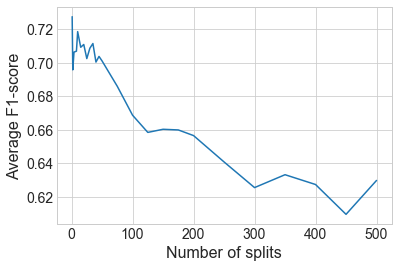

In [47]:
fig = plt.figure()
ax = plt.axes()

ax.plot(results['Splits'], results['F1-score']);
plt.ylabel('Average F1-score', size = 16)
plt.xlabel('Number of splits', size = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0.892, 0.894, 0.896, 0.898, 0.9  , 0.902, 0.904, 0.906, 0.908]),
 <a list of 9 Text yticklabel objects>)

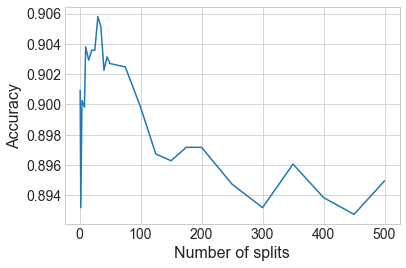

In [48]:
fig = plt.figure()
ax = plt.axes()

ax.plot(results['Splits'], results['Accuracy']);
plt.ylabel('Accuracy', size = 16)
plt.xlabel('Number of splits', size = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)